<a href="https://colab.research.google.com/github/paulagmar/NLP_KindleDatabase/blob/main/Kindle_ProyectoFinal_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto final NLP

Database: KINDLE book reviews



Installation of packages and libraries

In [ ]:
#install python 3.8 and dev utils
!sudo apt-get update -y
!sudo apt-get install python3.8 python3.8-dev python3.8-distutils libpython3.8-dev

#change alternatives
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 2

#Check that it points at the right location
!python3 --version

# install pip
!curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
!python3 get-pip.py --force-reinstall

#install colab's dependencies
!python3 -m pip install ipython ipython_genutils ipykernel jupyter_console prompt_toolkit httplib2 astor

# link to the old google package
!ln -s /usr/local/lib/python3.10/dist-packages/google \
       /usr/local/lib/python3.8/dist-packages/google

# There has got to be a better way to do this...but there's a bad import in some of the colab files
# IPython no longer exposes traitlets like this, it's a separate package now
!sed -i "s/from IPython.utils import traitlets as _traitlets/import traitlets as _traitlets/" /usr/local/lib/python3.8/dist-packages/google/colab/*.py
!sed -i "s/from IPython.utils import traitlets/import traitlets/" /usr/local/lib/python3.8/dist-packages/google/colab/*.py

import sys

!pip install gensim==3.8.3

import gensim
import gensim.models.wrappers

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'python3-distutils' instead of 'python3.8-distutils'
libpython3.8-dev is already the ne

After rexecuting previous cell, restart the execution environment and run it again.

In [ ]:
import os       #importing os to set environment variable
def install_java():
    !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
    !java -version       #check java version
install_java()

!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

os.environ['MALLET_HOME'] = 'mallet-2.0.8'
mallet_path = 'mallet-2.0.8/bin/mallet' # you should NOT need to change this

!pip3 install numpy pandas seaborn matplotlib termcolor nltk spacy
!pip3 install -U scikit-learn

# Common imports
import numpy as np
import pandas as pd
import zipfile as zp
from termcolor import colored
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import re
from collections import Counter
# Supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore',module='compress_fasttext')

openjdk version "11.0.18" 2023-01-17
OpenJDK Runtime Environment (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1)
OpenJDK 64-Bit Server VM (build 11.0.18+10-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
--2023-05-15 19:03:34--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2023-05-15 19:03:34--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  25.5MB/s    in 0.6s    

2023-05-15 19:03:35 (25.5 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/161847

In [ ]:
import nltk
from nltk.corpus import stopwords

# Data loading and preprocessing

Load the kindle book review dataset. It contains 12.000 reviews.

**Columns of interest**

* 'reviewText': contains the book reviews of each user in kindle
* 'rating': given by each user from 1 to 5


In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

#For fancy table Display
%load_ext google.colab.data_table

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


Load the database from Drive, which was downloaded from:

> https://www.kaggle.com/datasets/meetnagadia/amazon-kindle-book-review-for-sentiment-analysis

## Data preprocessing with spacy pipeline

Implementation of a pipeline for the preprocessing of the texts.

Due to the usefull preprocessing pipeline provided by Spacy we will use it for the cleaning of the database. This will include homogenization, lemmatization, stopword removal, sentence tokenization and filtering of non-English sentences.

In [ ]:
import spacy
from gensim.corpora import Dictionary

import locale
locale.getpreferredencoding = lambda: "UTF-8"

!python -m spacy download en_core_web_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.5.0/en_core_web_md-3.5.0-py3-none-any.whl (42.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
!python -m spacy download xx_sent_ud_sm
!pip install --upgrade spacy_langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 36.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('xx_sent_ud_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.5/320.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 998.1/998.1 kB 34.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.7-py3-none-any.whl size=993416 sha256=ab1f606853da410b8415d7d71547f0984925a6b787b3e7457ef7fb96cd10f4ce
  Stored in directory: /root/.cache/pip/wheels/c1/6d/ab/bf9ecd1ab14dd236da586dfd0d4b008e2e803e571cf2229c26
Successfully built langdetect


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP/all_kindle_review.csv', sep=',')

As we can see, the original textcontains contractions, non alphanumeric tokens, and generic stopwords like prepositions.

In [ ]:
print('============= Original Text =============')
print(data['reviewText'][0])

============= Original Text =============
Jace Rankin may be short, but he's nothing to mess with, as the man who was just hauled out of the saloon by the undertaker knows now. He's a famous bounty hunter in Oregon in the 1890s who, when he shot the man in the saloon, just finished a years long quest to avenge his sister's murder and is now trying to figure out what to do next. When the snotty-nosed farm boy he just rescued from a gang of bullies offers him money to kill a man who forced him off his ranch, he reluctantly agrees to bring the man to justice, but not to kill him outright. But, first he needs to tell his sister's widower the news.Kyla "Kyle" Springer Bailey has been riding the trails and sleeping on the ground for the past month while trying to find Jace. She wants revenge on the man who killed her husband and took her ranch, amongst other crimes, and she's not so keen on the detour Jace wants to take. But she realizes she's out of options, so she hides behind her boy pers

In [ ]:
from spacy.language import Language
from spacy_langdetect import LanguageDetector

# Add LanguageDetector and assign it a string name
@Language.factory("language_detector")
def create_language_detector(nlp, name):
    return LanguageDetector(language_detection_function=None)


In [ ]:
mult_nlp = spacy.load('xx_sent_ud_sm')
mult_nlp.add_pipe('language_detector', last=True)
nlp = spacy.load('en_core_web_md')
nlp.disable_pipe('parser')
nlp.disable_pipe('ner')

valid_POS = set(['VERB', 'NOUN', 'ADJ', 'PROPN'])
specific_stw = set(['love', 'man', 'lot', 'bit', 'book', 'Kindle', 'book', 'story', 'character', 'author',  'plot', 'reader', 'read', 'Amazon']) # 'good', 'find',


def text_preprocessing(rawtext):
  # 1. tokenization
  mult_doc = mult_nlp(rawtext)

  # 2. filtering
  # English and Spanish Texts
  english_text = ' '.join([sent.text for sent in mult_doc.sents if sent._.language['language']=='en'])

  # 3. POS
  doc = nlp(english_text)
  df = pd.DataFrame([[token.text, token.pos_, token.tag_] for token in doc],
                    columns = ['Token', 'POS', 'TAG'])

  # 4. Lemmatization and lowercase
  lemmas = (' '.join([token.lemma_.lower() for token in doc if token.is_alpha and token.pos_ in valid_POS
                      and not token.is_stop and token.lemma_ not in specific_stw]))

  return lemmas


print('============= Original text =============')
print(data['reviewText'][0])
print('\n============= Lemmatized text =============')
print(text_preprocessing(data['reviewText'][0]))

============= Original text =============
Jace Rankin may be short, but he's nothing to mess with, as the man who was just hauled out of the saloon by the undertaker knows now. He's a famous bounty hunter in Oregon in the 1890s who, when he shot the man in the saloon, just finished a years long quest to avenge his sister's murder and is now trying to figure out what to do next. When the snotty-nosed farm boy he just rescued from a gang of bullies offers him money to kill a man who forced him off his ranch, he reluctantly agrees to bring the man to justice, but not to kill him outright. But, first he needs to tell his sister's widower the news.Kyla "Kyle" Springer Bailey has been riding the trails and sleeping on the ground for the past month while trying to find Jace. She wants revenge on the man who killed her husband and took her ranch, amongst other crimes, and she's not so keen on the detour Jace wants to take. But she realizes she's out of options, so she hides behind her boy pers

After preprocessing the review with the spacy pipeline we can observe the removal of puntuation marks, stopwords or contractions.

**This lines only have to be executed once in order to get the processed dataset**

In [ ]:
data['reviewText_procesed'] = data['reviewText'].apply(text_preprocessing) # 20 min

In [ ]:
data.tail(5)

,Unnamed: 0.1,Unnamed: 0,asin,helpful,rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,reviewText_procesed
11995,11995,2183,B001DUGORO,"[0, 0]",4,Valentine cupid is a vampire- Jena and Ian ano...,"02 28, 2014",A1OKS5Q1HD8WQC,lisa jon jung,jena,1393545600,valentine cupid jena ian vampire friend vampir...
11996,11996,6272,B002JCSFSQ,"[2, 2]",5,I have read all seven books in this series. Ap...,"05 16, 2011",AQRSPXLNEQAMA,TerryLP,Peacekeepers Series,1305504000,series apocalyptic adventure favorite genre se...
11997,11997,12483,B0035N1V7K,"[0, 1]",3,This book really just wasn't my cuppa. The si...,"07 26, 2013",A2T5QLT5VXOJAK,hwilson,a little creepy,1374796800,cuppa situation capture woman workplace tie ha...
11998,11998,3640,B001W1XT40,"[1, 2]",1,"tried to use it to charge my kindle, it didn't...","09 17, 2013",A28MHD2DDY6DXB,"Allison A. Slater ""Gryphon50""",didn't work,1379376000,try use charge kindle register charge worthles...
11999,11999,11398,B003370JUS,"[5, 6]",3,Taking Instruction is a look into the often hi...,"07 5, 2012",A3JUXLB4K9ZXCC,Dafna Yee,"If you like BDSM with a touch of romance, this...",1341446400,take instruction look hide world sexual bdsm j...


In [ ]:
# Drop unnecesary columns
data_dropeed = data.drop(['asin','helpful', 'reviewTime', 'reviewerID', 'reviewerName', 'unixReviewTime', 'summary', 'Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=False)
data_dropeed.tail(5)

,rating,reviewText,reviewText_procesed
11995,4,Valentine cupid is a vampire- Jena and Ian ano...,valentine cupid jena ian vampire friend vampir...
11996,5,I have read all seven books in this series. Ap...,series apocalyptic adventure favorite genre se...
11997,3,This book really just wasn't my cuppa. The si...,cuppa situation capture woman workplace tie ha...
11998,1,"tried to use it to charge my kindle, it didn't...",try use charge kindle register charge worthles...
11999,3,Taking Instruction is a look into the often hi...,take instruction look hide world sexual bdsm j...


In [ ]:
data_dropeed = data_dropeed[[len(review.split()) != 0 for review in data_dropeed['reviewText_procesed']]] # Short reviews after stopwords become empty, we remove them
data_dropeed.to_csv('clean_data_kindle_minusc_stop.csv') # Save data as csv
data = data_dropeed

Once saved the dataframe, we can avoid executing the previous code every time we access the notebook.

## Loading clean data

**This can be executed in order to avoid previous demanding code.**

In [ ]:
dataloaded = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP/clean_data_kindle_minusc_stop.csv', sep=',')
dataloaded.drop('Unnamed: 0', axis=1, inplace=True)
dataloaded = dataloaded.dropna() # Short reviews after stopwords become empty, resulting in NaNs
data = dataloaded

In [ ]:
data.tail(5)

,rating,reviewText,reviewText_procesed
11986,4,Valentine cupid is a vampire- Jena and Ian ano...,valentine cupid jena ian vampire friend vampir...
11987,5,I have read all seven books in this series. Ap...,series apocalyptic adventure favorite genre se...
11988,3,This book really just wasn't my cuppa. The si...,cuppa situation capture woman workplace tie ha...
11989,1,"tried to use it to charge my kindle, it didn't...",try use charge kindle register charge worthles...
11990,3,Taking Instruction is a look into the often hi...,take instruction look hide world sexual bdsm j...


In [ ]:
# Filter the original dataframe to get only reviews with more than 30 tokens (Read section Data Analysis)
data_30 = data.loc[[len(review.split()) > 30 for review in data['reviewText_procesed']], :]
print(f'Initial number of reviews: {data.shape[0]}')

# Reset the index of the new dataframe
data_30 = data_30.reset_index(drop=True)

Initial number of reviews: 11991


# Data Analysis

Let's check how is the distribution of the **length of each review** with the following histogram:

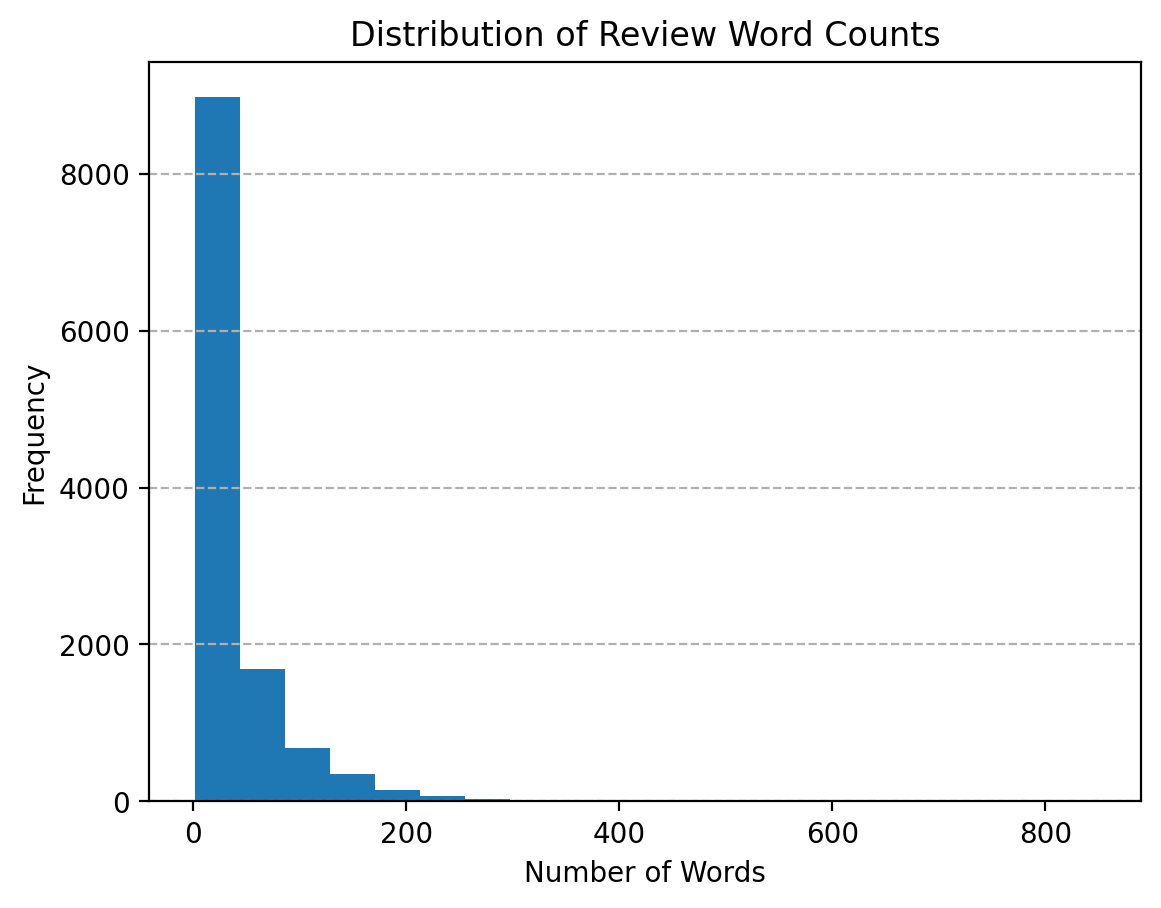

In [ ]:
# Split each review into words using the `split()` method and get the length of the resulting list
review_word_counts = [len(review.split()) for review in data['reviewText_procesed']]

# Create a histogram using `hist()` method from matplotlib
plt.hist(review_word_counts, bins=20)

# Set the title and axis labels
plt.title("Distribution of Review Word Counts")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--')
# Show the histogram
plt.show()

We have many reviews with a few number of words. Lets get a more informative histogram using a logaritmic x axis:

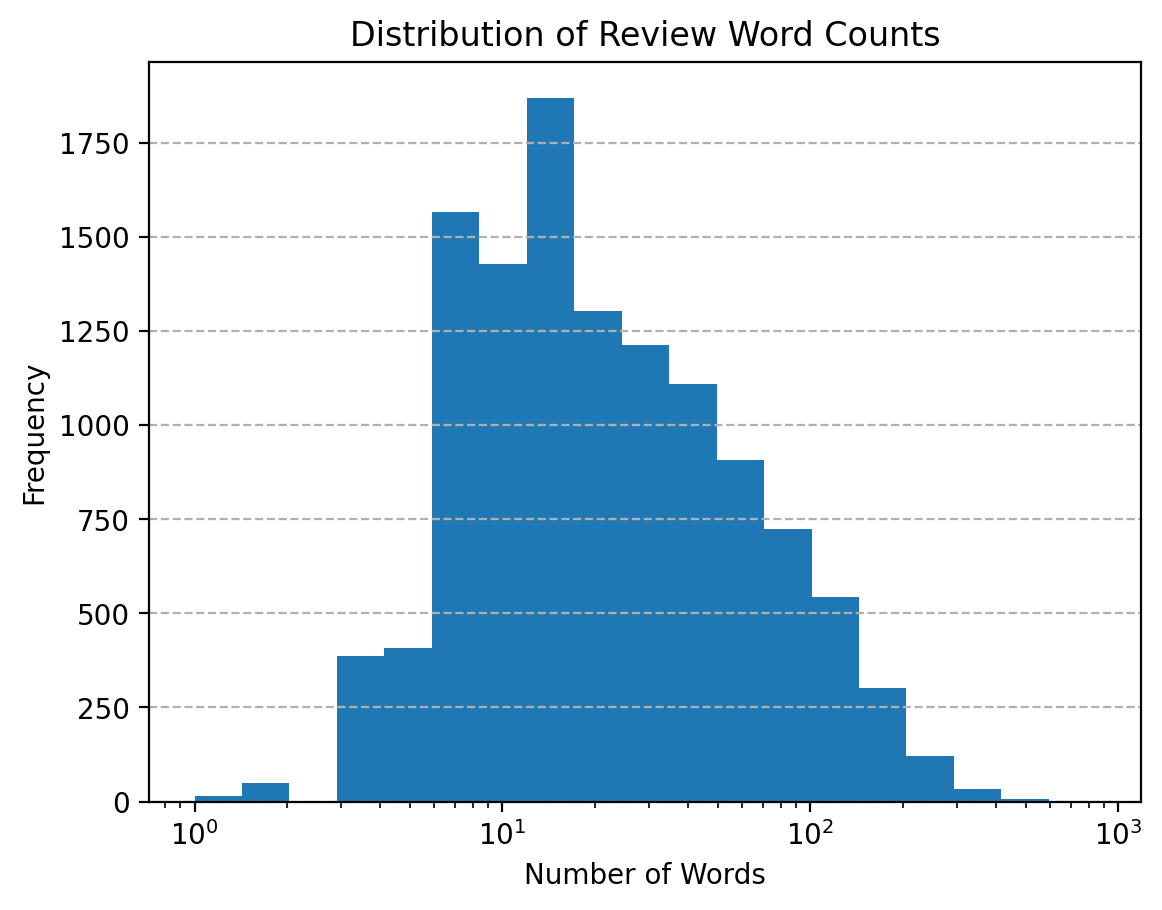

In [ ]:
# Split each review into words using the `split()` method and get the length of the resulting list
review_word_counts = [len(review.split()) for review in data['reviewText_procesed']]

# Histogram
log_bins = np.logspace(np.log10(min(review_word_counts)), np.log10(max(review_word_counts)), 20)
plt.hist(review_word_counts, bins=log_bins)

# Title and axis labels
plt.title("Distribution of Review Word Counts")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")

# Set the x-axis scale to logarithmic
plt.xscale('log')
plt.grid(axis='y', linestyle='--')
plt.show()


We can see that there are meny reviews that are not long enough to provide relevant information for our models. Therefore we have discarded those reviews with a lenght shorter than 30 tokens, as we represent in gray in the following histogram:

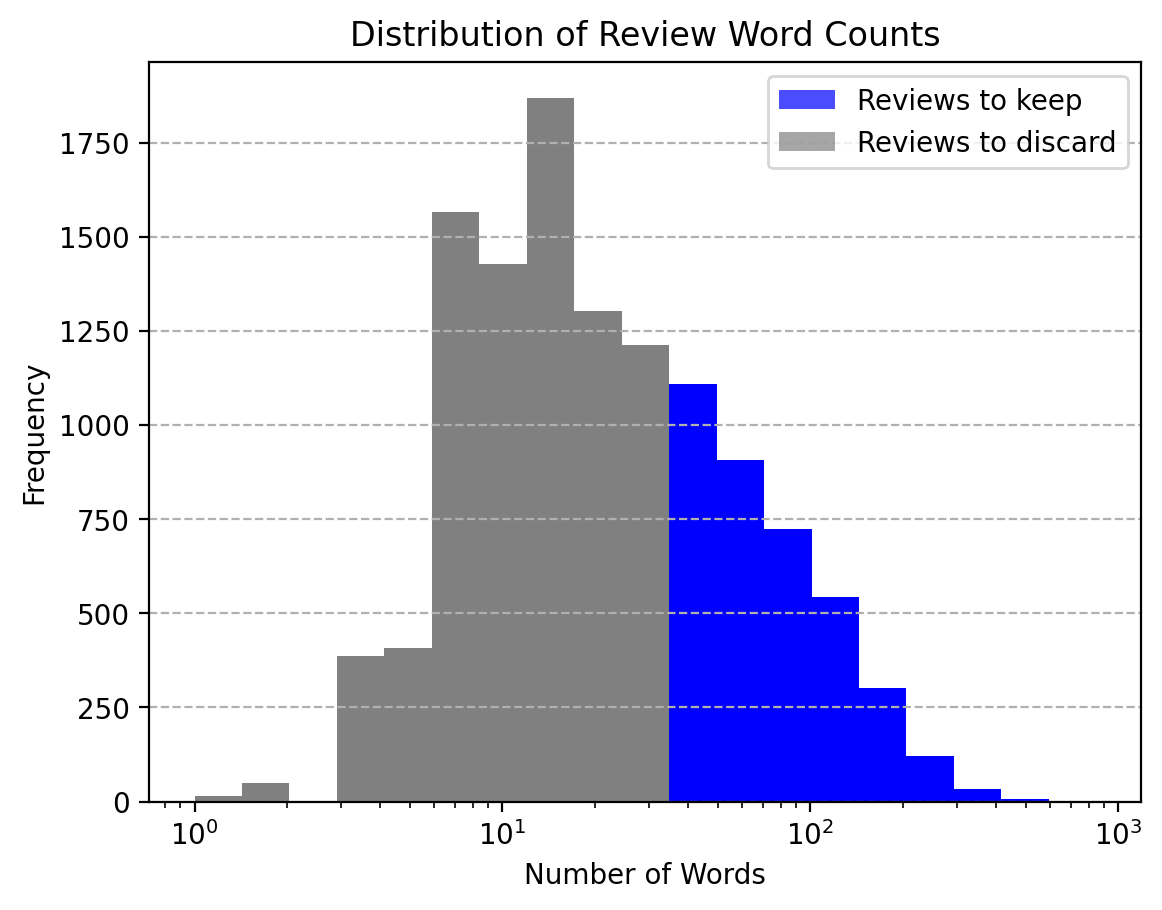

In [ ]:
# Split each review into words using the `split()` method and get the length of the resulting list
review_word_counts = [len(review.split()) for review in data['reviewText_procesed']]

# Histogram
log_bins = np.logspace(np.log10(min(review_word_counts)), np.log10(max(review_word_counts)), 20)
counts, bins, patches = plt.hist(review_word_counts, bins=log_bins, color='blue')

# Highlight bins with values less than 30 in red
red_threshold = 30
for i, count in enumerate(counts):
    if bins[i] < red_threshold:
        patches[i].set_fc('gray')

# Title and axis labels
plt.title("Distribution of Review Word Counts")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")

# Set the x-axis scale to logarithmic
plt.xscale('log')
# Legend
blue_patch = plt.Rectangle((0,0), 1, 1, fc='blue', alpha=0.7)
gray_patch = plt.Rectangle((0,0), 1, 1, fc='gray', alpha=0.7)
plt.legend([blue_patch, gray_patch], ['Reviews to keep', 'Reviews to discard'])
plt.grid(axis='y', linestyle='--')
plt.show()


In [ ]:
# Let's print the initial number of reviews
print(f'Initial number of reviews: {data.shape[0]}')

# Filter the original dataframe to get only reviews with more than 50 tokens
data_30 = data.loc[[len(review.split()) > 30 for review in data['reviewText_procesed']], :]
data_30 = data_30.reset_index(drop=True)    # Reset the index of the new dataframe
print(f'Number of reviews with more than 30 words: {data_30.shape[0]}')

# Average number of words in 'reviewText_processed'
ave_words = np.mean([len(review.split()) for review in data_30['reviewText_procesed']])
print(f"Average number of words in 'reviewText_processed' after filtering reviews with less than 30 words is {ave_words:.2f}")

Initial number of reviews: 11991
Number of reviews with more than 30 words: 4156
Average number of words in 'reviewText_processed' after filtering reviews with les than 30 words is 80.25


Initially we had 12000 reviews. After preprocessing, we have 11991 reviews that were non empty, and if we filter those with less than 30 words, we stay with 4156 of them.

Let's now check the **distribution of scores** in the reviews.

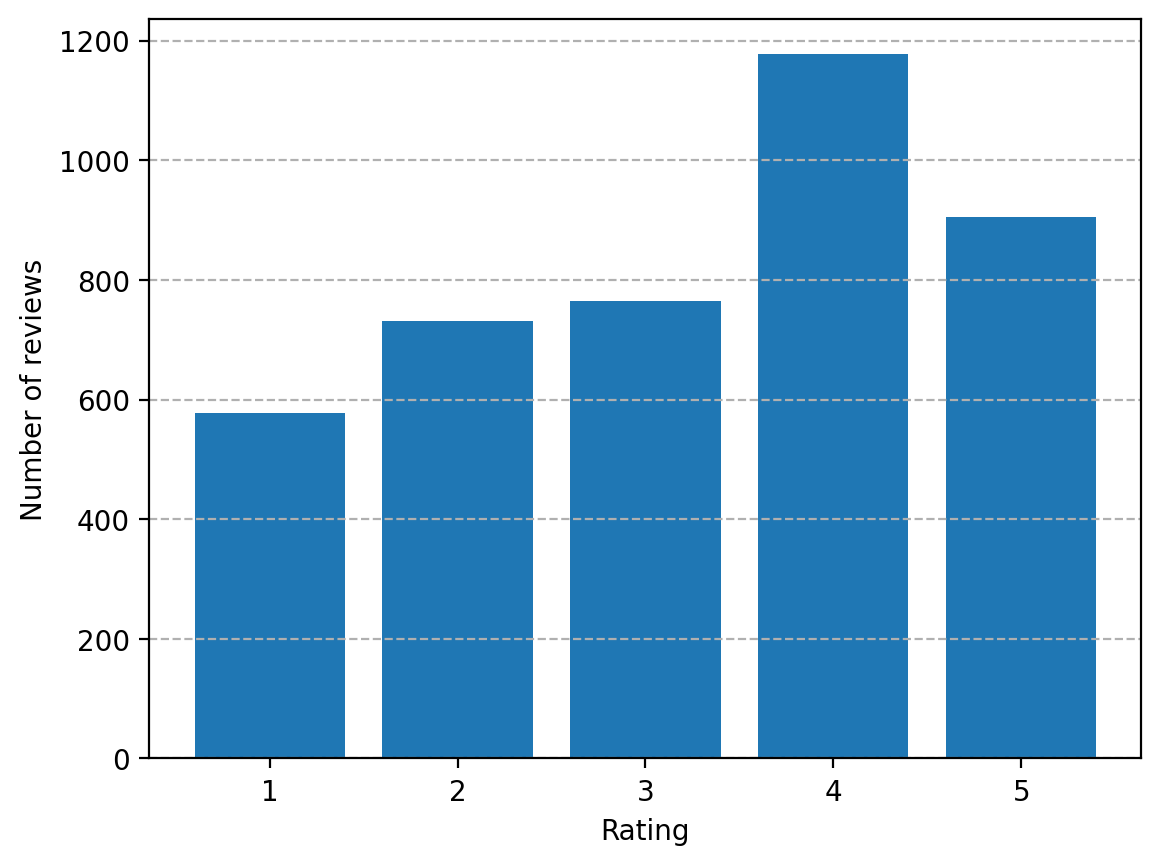

In [ ]:
# Number of reviews per rating
counts = data_30['rating'].value_counts()

# Bar graph representation of the obtained distribution
plt.bar(counts.index, counts.values)
plt.grid(axis='y', linestyle='--')
plt.xlabel('Rating')
plt.ylabel('Number of reviews')
plt.show()

In [ ]:
# Freq of each value in rating column
counts = data_30['rating'].value_counts()
most_frequent_value_percent = 100 * counts.max() / counts.sum()

print(f"The most frequent rating is {counts.idxmax()}, being the {most_frequent_value_percent:.2f}% of the total ratings.")


The most frequent rating is 4, being the 28.32% of the total ratings.


The most common rating is 4/5, and it represents the 28.35% of total ratings. Although there is a certain class inbalance, it does not seem to be too critical. We have to therefore consider that the baseline for our following classification models is a 28.35% of accuracy, that would be obtained by simply classifying all the reviews as 4/5.

# Bag of words  BoW

We create our corpus based in the column 'reviewText_procesed' that contains the book reviews of each user

In [ ]:
corpus = [a.split() for a in data_30['reviewText_procesed']]

print(colored('Number of documents in corpus: '+str(len(corpus)), 'green'))
print(colored('\n============= First review =============', 'blue'))
print(corpus[0])

Number of documents in corpus: 4156

============= First review =============
['jace', 'rankin', 'short', 'mess', 'haul', 'saloon', 'undertaker', 'know', 'famous', 'bounty', 'hunter', 'oregon', 'shoot', 'saloon', 'finish', 'year', 'long', 'quest', 'avenge', 'sister', 'murder', 'try', 'figure', 'snotty', 'nosed', 'farm', 'boy', 'rescue', 'gang', 'bully', 'offer', 'money', 'kill', 'force', 'ranch', 'agree', 'bring', 'justice', 'kill', 'need', 'tell', 'sister', 'widower', 'news', 'kyla', 'kyle', 'springer', 'bailey', 'ride', 'trail', 'sleep', 'ground', 'past', 'month', 'try', 'jace', 'want', 'revenge', 'kill', 'husband', 'take', 'ranch', 'crime', 'keen', 'detour', 'jace', 'want', 'realize', 'option', 'hide', 'boy', 'persona', 'try', 'pace', 'confrontation', 'way', 'get', 'shot', 'jace', 'discover', 'kyle', 'kyla', 'come', 'clean', 'reason', 'need', 'scoundrel', 'dead', 'hope', 'help', 'share', 'touch', 'moment', 'bloom', 'romance', 'kyla', 'reason', 'fear', 'hide', 'boy', 'persona', 'watc

N-gram detection (words that usually appear together as 'machine learning').

In [ ]:
from gensim.models.phrases import Phrases

phrase_model = Phrases(corpus, min_count=2, threshold=20)

print(colored('\n============= First review in corpus =============', 'blue'))
print(corpus[0])
corpus = [el for el in phrase_model[corpus]] # We populate corpus again
print(colored('\n============= First review after N-gram replacement =============', 'blue'))
print(corpus[0])


============= First review in corpus =============
['jace', 'rankin', 'short', 'mess', 'haul', 'saloon', 'undertaker', 'know', 'famous', 'bounty', 'hunter', 'oregon', 'shoot', 'saloon', 'finish', 'year', 'long', 'quest', 'avenge', 'sister', 'murder', 'try', 'figure', 'snotty', 'nosed', 'farm', 'boy', 'rescue', 'gang', 'bully', 'offer', 'money', 'kill', 'force', 'ranch', 'agree', 'bring', 'justice', 'kill', 'need', 'tell', 'sister', 'widower', 'news', 'kyla', 'kyle', 'springer', 'bailey', 'ride', 'trail', 'sleep', 'ground', 'past', 'month', 'try', 'jace', 'want', 'revenge', 'kill', 'husband', 'take', 'ranch', 'crime', 'keen', 'detour', 'jace', 'want', 'realize', 'option', 'hide', 'boy', 'persona', 'try', 'pace', 'confrontation', 'way', 'get', 'shot', 'jace', 'discover', 'kyle', 'kyla', 'come', 'clean', 'reason', 'need', 'scoundrel', 'dead', 'hope', 'help', 'share', 'touch', 'moment', 'bloom', 'romance', 'kyla', 'reason', 'fear', 'hide', 'boy', 'persona', 'watch', 'jace', 'pull', 'shell

In [ ]:
from gensim import corpora
D = Dictionary(corpus)

no_below = 4 #Minimum number of documents to keep a term in the dictionary
no_above = .80 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')


The dictionary contains 8134 terms


In [ ]:
reviews_bow = [D.doc2bow(doc) for doc in corpus]

n_review = 1000
print(colored('============= Review (lemmas) =============', 'blue'))
print(' '.join(corpus[n_review]))

print(colored('\n============= Sparse vector representation =============', 'blue'))
print(reviews_bow[n_review])

print(colored('\n============= Word counts for the review =============', 'blue'))
print(list(map(lambda x: (D[x[0]], x[1]), reviews_bow[n_review])))


============= Review (lemmas) =============
enjoy reading jane_porter antonio villereal santos lily tyler jan jacqueas big birthday bash mansion antonio step brother dirk jane lily business_partner event planning company call help host big lavish massacre bdsm weekend lily girl weekend jane require help event take_place assume wise engaged birthday boy antonio snag attention bff santos keep distracted miss breakfast brunch dinner sit scorcher wet start finish want miss reading

============= Sparse vector representation =============
[(11, 1), (32, 1), (43, 1), (51, 2), (61, 1), (135, 1), (148, 2), (152, 1), (171, 1), (330, 1), (431, 1), (452, 1), (464, 1), (625, 1), (725, 2), (730, 2), (753, 2), (837, 1), (918, 1), (990, 1), (1221, 2), (1255, 1), (1334, 1), (1428, 1), (1504, 3), (2169, 1), (2250, 1), (2252, 1), (2274, 2), (2389, 1), (2489, 1), (2573, 1), (2936, 1), (2996, 1), (4133, 1), (4195, 3), (4326, 2), (4579, 1), (4732, 1), (4934, 1), (5265, 1), (6249, 1), (6871, 1), (7015, 2)]


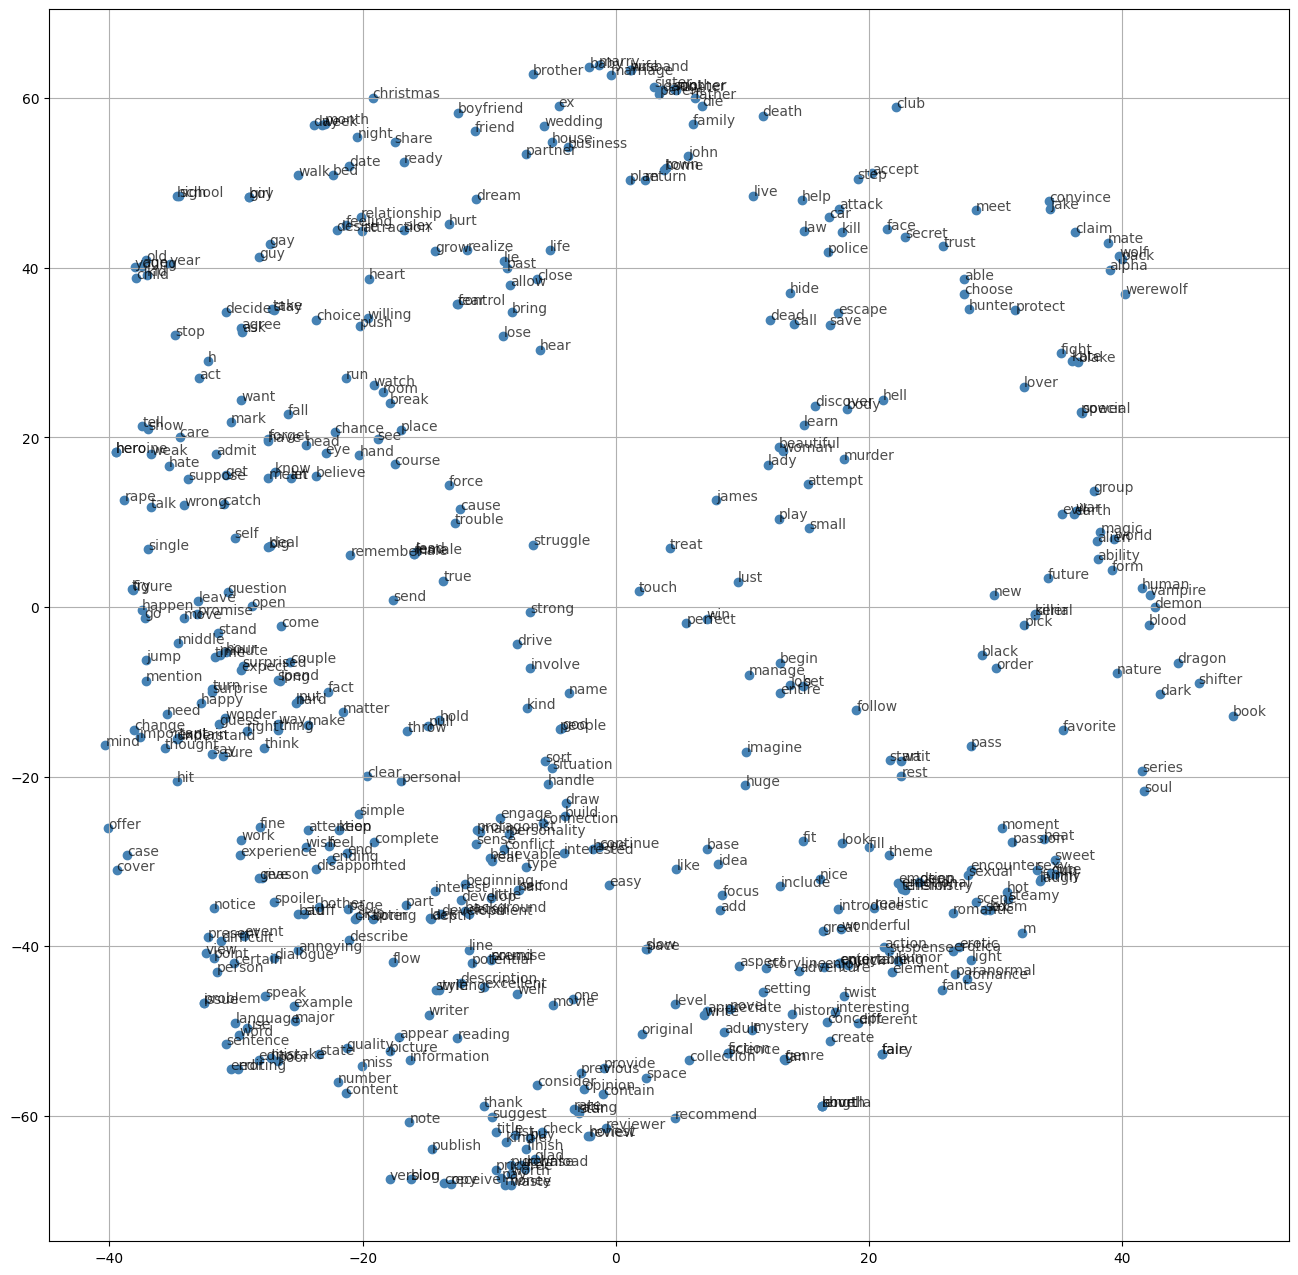

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(init='random')
embed_tsne = tsne.fit_transform(wv.vectors)

# We plot only 500 embeddings
fig, ax = plt.subplots(figsize=(16, 16))
for idx, word in enumerate((list(wv.key_to_index.keys())[:500])):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(word, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

plt.grid()

If we analyze the obtained representation, we find some very semantically related words represented together, such as "vampire", "demon" and "blood" (at the middle right), "partner" and "wedding" (at the middle top) or "kill" and "attack" (at the middle top), so in general we get a good performance.

# Vector representation
* TFIDF
* word embedding models
* the LDA algorithm


## TFIDF Representation

In [ ]:
from gensim.models import TfidfModel

tfidf = TfidfModel(reviews_bow)

reviews_tfidf = tfidf[reviews_bow]
n_project = 1000
print(colored('============= TFIDF representation for the project =============', 'blue'))
print(reviews_tfidf[n_review])

print(colored('\n============= TFIDF applying the transformation only to the document =============', 'blue'))
print(tfidf[reviews_bow[n_review]])

============= TFIDF representation for the project =============
[(11, 0.07667326332024711), (32, 0.03154568595876068), (43, 0.053042711257646306), (51, 0.09209742075924683), (61, 0.05083735932132554), (135, 0.02402121574221434), (148, 0.12076066520222804), (152, 0.05815226866416354), (171, 0.05836549123865241), (330, 0.035853048763684205), (431, 0.11611601677309648), (452, 0.12928255681445328), (464, 0.09241327537939123), (625, 0.08859521588066699), (725, 0.1517748793429419), (730, 0.1291347327033332), (753, 0.1517748793429419), (837, 0.0631135555921757), (918, 0.08486421605666178), (990, 0.13475887380594617), (1221, 0.23601889892491754), (1255, 0.08247168553280948), (1334, 0.13692318092794495), (1428, 0.096617496664486), (1504, 0.37072709817795946), (2169, 0.14502256887359738), (2250, 0.09116868789845428), (2252, 0.11274568975468079), (2274, 0.19985265182771134), (2389, 0.08374536723597271), (2489, 0.13475887380594617), (2573, 0.0899887842065736), (2936, 0.14502256887359738), (2996, 

## Word embeddings, Word2Vec

In [ ]:
from gensim.models import Word2Vec

sentences = [doc.split() for doc in data_30['reviewText_procesed']]

In [ ]:
%%time
model_w2v = Word2Vec(sentences=sentences, vector_size=200, window=5, min_count=10, sg=1, seed=42)

CPU times: user 10.8 s, sys: 22.8 ms, total: 10.8 s
Wall time: 5.68 s


In [ ]:
word_vectors = model_w2v.wv.vectors
word_vectors

array([[ 0.10857093,  0.23541582,  0.07466849, ...,  0.01557516,
        -0.07377381,  0.22555771],
       [ 0.2225388 ,  0.13472413,  0.06868784, ...,  0.04121438,
         0.09996404, -0.0329374 ],
       [ 0.19535619,  0.15519829,  0.02005184, ...,  0.09803983,
         0.0901709 , -0.05490928],
       ...,
       [ 0.1205221 ,  0.06594096,  0.00822159, ...,  0.12466598,
         0.09920095, -0.02992013],
       [ 0.2092167 ,  0.11839853, -0.01136129, ...,  0.05567587,
         0.03599903,  0.01872763],
       [ 0.13637674,  0.1264666 , -0.04791797, ...,  0.07017918,
         0.0581601 , -0.01402258]], dtype=float32)

In [ ]:
dir(model_w2v.wv)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_load_specials',
 '_log_evaluate_word_analogies',
 '_save_specials',
 '_smart_save',
 '_upconvert_old_d2vkv',
 '_upconvert_old_vocab',
 'add_lifecycle_event',
 'add_vector',
 'add_vectors',
 'allocate_vecattrs',
 'closer_than',
 'cosine_similarities',
 'distance',
 'distances',
 'doesnt_match',
 'evaluate_word_analogies',
 'evaluate_word_pairs',
 'expandos',
 'fill_norms',
 'get_index',
 'get_mean_vector',
 'get_normed_vectors',
 'get_vecattr',
 'get_vector',
 'has_index_for',
 'index2entity',
 'index2word',
 'index_to_key',
 'init_sims',
 

In [ ]:
print(colored('\n============= Word2Vec vocabulary =============', 'blue'))
words = list(model_w2v.wv.key_to_index)
print(words[0:50])
print(colored('\n============= Embedding of the first word =============', 'blue'))
print(model_w2v.wv[words[0]])


============= Word2Vec vocabulary =============
['time', 'know', 'want', 'think', 'like', 'go', 'get', 'feel', 'series', 'thing', 'sex', 'way', 'come', 'end', 'write', 'little', 'enjoy', 'life', 'romance', 'work', 'short', 'woman', 'year', 'scene', 'start', 'look', 'take', 'great', 'need', 'review', 'try', 'give', 'leave', 'friend', 'tell', 'novel', 'bad', 'world', 'relationship', 'people', 'happen', 'new', 'star', 'hot', 'make', 'interesting', 'turn', 'guy', 'page', 'help']

============= Embedding of the first word =============
[ 0.10857093  0.23541582  0.07466849 -0.02038274  0.02570965  0.0947872
 -0.06606566  0.25484705 -0.28325838 -0.06651998 -0.1909581   0.25828537
 -0.18398333  0.27700582 -0.07273012 -0.12128466  0.07530564 -0.2775201
  0.03742636  0.0531111   0.16876645 -0.0855713  -0.18321314  0.33519942
  0.1990891   0.17245065 -0.01435044  0.3011121   0.0853475  -0.31537405
  0.01401529 -0.3379722  -0.10424729 -0.01735839 -0.12346964 -0.09158312
  0.20493454 -0.13531756  

In [ ]:
from gensim.models import KeyedVectors

# Store just the words + their trained embeddings.
wv = model_w2v.wv

wv.most_similar(positive="vampire")

[('witch', 0.8373213410377502),
 ('angel', 0.8359465003013611),
 ('blood', 0.7907177805900574),
 ('human', 0.7838262915611267),
 ('brett', 0.7804258465766907),
 ('lisa', 0.7757962346076965),
 ('immortal', 0.7675018310546875),
 ('demon', 0.7586812973022461),
 ('hunt', 0.7555953860282898),
 ('guild', 0.7542239427566528)]

In [ ]:
D = Dictionary(sentences)          # Obtain dictionary

def get_vocabulary_coverage(model, gensim_dict):

  words_model = list(model.key_to_index)          # Words in the model vocab
  words_dict = list(gensim_dict.token2id.keys())  # Text vocab
  covered_words = set(words_model).intersection(words_dict) # Intersection between both sets
  coverage = len(covered_words) / len(words_dict) # Coverage of the model

  return coverage

# Use function "get_vocabulary_coverage" to calculate coverage and print result
print('The {:.2f}% of the dictionary is covered by the model'.format(get_vocabulary_coverage(wv, D)*100))


The 21.14% of the dictionary is covered by the model


In [ ]:
def get_review_vector(model, review):

  filtered_OOV = set(model.key_to_index).intersection(review) # Interseccion
  embeddings = model[filtered_OOV]  # Returns a ist of list, with len = #words, and each word with 200 element (embedding size)
  vec = np.mean(embeddings, axis=0) # Mean of the embeddings of the words from the given review (size 200)

  return vec

# Calculate embedding vectors for each review and save them in a sparse matrix
vectors = [get_review_vector(wv, review) for review in sentences]

In [ ]:
matrix_w2v = np.matrix(vectors)
print(matrix_w2v.shape)

(4156, 200)


## LDA with Mallet

In [ ]:
!pip3 install pyLDAvis==2.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.7/381.7 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 39.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97721 sha256=6541978ad67fd28db4b7cf333c7364c1bc90fcb69e5a0b4d9e5a8c22a82d929d
  Stored in directory: /root/.cache/pip/wheels/31/8c/a0/24a443892f2134e691d59c8c6c35e19821e02f85e49871f8fd
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492022 sha256=a0d95f722a7696c786bd434512201b9d6ee78ca4d64c02eee935dad1e864b155
  Stored in directory: /root/.cache/pip/wheels/a0/0b/ee/e6994fadb42c1354dcccb139b0bf2795271bddfe6253ccdf11
Successfully built pyLDAvis future


In [ ]:
from gensim.models.wrappers import LdaMallet
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
from gensim.models.coherencemodel import CoherenceModel

Mallet LDA: 5 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 630
total tokens: 248412
<10> LL/token: -9.0784
<20> LL/token: -8.80728
<30> LL/token: -8.66218
<40> LL/token: -8.5876

0	1	series sex romance enjoy scene feel short novella thing hot start fun end erotic time give book sex_scene relationship erotica 
1	1	end write heroine point hero people feel enjoy thing action happen time bad give life main work kill place person 
2	1	woman friend relationship life time year guy thing hot feel leave father family girl feeling meet work brother night fall 
3	1	world life mate time live year human meet werewolf tale pack wolf family turn make discover save case death power 
4	1	time write review short page end feel thing work start free buy bad interesting enjoy star main writing word chapter 

<50> LL/token: -8.53898
<60> LL/token: -8.50893
<70> LL/token: -8.48442
<80> LL/token: -8.4691
<90> LL/token: -8.45188

0	1	series sex romance enjoy short vampire feel hot novella scen

For n_topics = 5, Topic coherence = 0.3250760100436342


Mallet LDA: 6 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 630
total tokens: 248412
<10> LL/token: -9.17216
<20> LL/token: -8.91106
<30> LL/token: -8.75159
<40> LL/token: -8.66161

0	0.83333	feel short write thing time end start series bad review enjoy sex star great writing page main finish scene heroine 
1	0.83333	time write work end review interesting word issue page cover people thing buy give case make free include bad writer 
2	0.83333	life enjoy family mystery work kill time happen make child leave people start friend end real person woman year murder 
3	0.83333	world series vampire human tale enjoy great start fantasy set end romance life interesting action hope magic future feel learn 
4	0.83333	romance sex woman hot series mate relationship sexy brother scene thing strong fun werewolf meet pack heroine wolf feel alpha 
5	0.83333	life year friend time thing feel woman father relationship leave guy work end live marry meet decide feeling day wife 

<50> LL/toke

For n_topics = 6, Topic coherence = 0.32367313638739265


Mallet LDA: 7 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 630
total tokens: 248412
<10> LL/token: -9.23604
<20> LL/token: -8.94015
<30> LL/token: -8.78918
<40> LL/token: -8.69232

0	0.71429	series mate romance enjoy vampire fun werewolf hot pack sexy wolf great alpha sex brother strong leave start life meet 
1	0.71429	world human action life people tale set kill interesting vampire fantasy create war dark learn begin live group magic adventure 
2	0.71429	relationship friend hot life sex feel woman time year family thing guy night romance sexy start meet turn feeling past 
3	0.71429	short review write series time page buy end great free start star enjoy work thing bad finish chapter interesting feel 
4	0.71429	woman time heroine hero end year brother father sex thing happen guy leave life marry feel husband meet fall people 
5	0.71429	feel write time thing scene work end bad romance main sex give writing page idea interesting development point enjoy sex_scene 
6	0.7142

For n_topics = 7, Topic coherence = 0.3453800894378918


Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 630
total tokens: 248412
<10> LL/token: -9.29804
<20> LL/token: -8.98668
<30> LL/token: -8.8266
<40> LL/token: -8.74565

0	0.625	sex hot relationship woman romance sexy friend scene feel series erotic sex_scene feeling guy time leave year life family brother 
1	0.625	vampire enjoy world short great series write human tale time fun work end interesting feel action include collection recommend set 
2	0.625	series enjoy romance feel short end thing work write review book start great time fun give expect interesting main develop 
3	0.625	mate father woman meet year heroine thing friend hero brother marry life time husband mother feel wife leave werewolf pack 
4	0.625	write time end page review bad issue thing writing free work star chapter writer word people buy give interesting day 
5	0.625	time start feel thing short review write word finish bad series enjoy end happen people star point great buy description 
6	0

For n_topics = 8, Topic coherence = 0.3242289735305548


Mallet LDA: 9 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 630
total tokens: 248412
<10> LL/token: -9.33333
<20> LL/token: -9.01362
<30> LL/token: -8.85791
<40> LL/token: -8.76302

0	0.55556	world series mate vampire human werewolf pack wolf alpha great meet fight learn life start shifter dragon follow strong kill 
1	0.55556	heroine hero woman sex time turn thing fall meet scene start give life feel rape call case people bad year 
2	0.55556	feel write thing main time interesting star bad end writing action people point start real problem gay scene enjoy lack 
3	0.55556	time thing feel happen end people guy work enjoy alex life finish hate year woman give great write bad big 
4	0.55556	write time page review free buy work short end chapter word writing cover star issue thing day pay mystery worth 
5	0.55556	end feel dark relationship leave start time life work make mark fact kill romance aspect scene bring give world fantasy 
6	0.55556	life work husband time wife year 

For n_topics = 9, Topic coherence = 0.3439627775202795


Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 630
total tokens: 248412
<10> LL/token: -9.37537
<20> LL/token: -9.04088
<30> LL/token: -8.88368
<40> LL/token: -8.79834

0	0.5	world series interesting enjoy write work mystery action time fantasy set great main develop create development tale people point human 
1	0.5	life world live series human learn vampire father bring family mother tale meet year war heart leave feel fight change 
2	0.5	end feel vampire give leave start time short life dark enjoy happen review thing turn work fact detail live sort 
3	0.5	woman friend time brother meet leave family life year mate guy relationship husband hot run day marry series sexy wait 
4	0.5	feel people time year give kill enjoy life begin year_old kid leave happen follow adult problem start fact save series 
5	0.5	short review time write free work buy great page pay star day price cover case version thing title purchase download 
6	0.5	sex relationship romance hot 

For n_topics = 10, Topic coherence = 0.36237372896649317


Mallet LDA: 12 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 630
total tokens: 248412
<10> LL/token: -9.44021
<20> LL/token: -9.09164
<30> LL/token: -8.93367
<40> LL/token: -8.83988

0	0.41667	people thing time write feel word bad point main work issue end lack review interesting problem writing line writer error 
1	0.41667	world case turn kill end life house max work emma great land discover place simon dark wait face run king 
2	0.41667	woman friend hot relationship sex guy sexy time year night life romance feeling thing work brother turn business share realize 
3	0.41667	father leave life short work happen family meet start end year friend woman thing write brother son mother time live 
4	0.41667	feel relationship husband time life woman romance leave year hero end marry wife thing fall enjoy scene lose marriage guy 
5	0.41667	write time short work free earth description alien make world adventure set include cover page start tale enjoy life build 
6	0.41667	day tim

For n_topics = 12, Topic coherence = 0.35205145480735944


Mallet LDA: 15 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 630
total tokens: 248412
<10> LL/token: -9.51649
<20> LL/token: -9.15457
<30> LL/token: -8.96879
<40> LL/token: -8.86746

0	0.33333	mate feel series give end time review make start change max word follow thing head adam claim order finish meet 
1	0.33333	sex hot relationship sexy short sex_scene romance erotic scene woman feel erotica friend sexual novella end enjoy couple night feeling 
2	0.33333	time interesting main write thing feel page point work hard place people god issue develop writing event bad line writer 
3	0.33333	woman hero brother heroine life sister time pack day alpha meet care thing run romance bad fall girl house wedding 
4	0.33333	series romance book feel enjoy start werewolf fun paranormal hunter thing kaylee light recommend give mate conflict wolf happen short 
5	0.33333	time gay relationship enjoy romance friend mystery thing kelly year emma play girl fun sweet couple age hard work guy 

For n_topics = 15, Topic coherence = 0.34622506132427905


Mallet LDA: 17 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 630
total tokens: 248412
<10> LL/token: -9.55008
<20> LL/token: -9.178
<30> LL/token: -8.99578
<40> LL/token: -8.89802

0	0.29412	series short romance sex enjoy novella vampire great fun erotica erotic hot dragon length sexy couple feel light review expect 
1	0.29412	mystery year_old father kid write live young friend age murder family life work killer year kill great experience time mother 
2	0.29412	mate series werewolf wolf pack alpha case shifter thing start action human female protect order end meet place run robyn 
3	0.29412	life work meet set draw person give change world family year feel lead leave end provide relationship follow dream turn 
4	0.29412	feel time end bad thing writing write idea point work page give scene people main happen lack review detail potential 
5	0.29412	write short review free chapter time end buy writer enjoy writing finish people page start word work star series point 
6	0.

For n_topics = 17, Topic coherence = 0.3388021761961087


Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 630
total tokens: 248412
<10> LL/token: -9.59137
<20> LL/token: -9.18911
<30> LL/token: -9.01766
<40> LL/token: -8.91809

0	0.25	series world enjoy dragon set review book action great trilogy draw continue end write romance make future war fantasy introduce 
1	0.25	vampire feel human kill end happen kate thing fall life give fight world demon enjoy leave evil michael boy live 
2	0.25	people life world kid time group leave thing meet animal year action young live lose start bring alien camp happen 
3	0.25	series short enjoy novella romance great fun develop end interesting write development fan ending work humor pick start quick length 
4	0.25	series short enjoy nice novella great make pick time fun romance bar m_m end joe involve feel scene day world 
5	0.25	world write human interesting set order family thing time heroine earth involve society detail fight enjoyable odd scene post power 
6	0.25	mate series 

For n_topics = 20, Topic coherence = 0.36576250411068223


Mallet LDA: 22 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 630
total tokens: 248412
<10> LL/token: -9.60742
<20> LL/token: -9.20152
<30> LL/token: -9.02216
<40> LL/token: -8.92576

0	0.22727	vampire world human life series fight kill demon change action learn fall give strong start pride end face power animal 
1	0.22727	feel enjoy kid great time write thing give set nice fact tale work jake year_old make fairy_tale hard type mind 
2	0.22727	mate werewolf wolf pack alpha meet dragon leave woman hunter family life brother thing strong series shifter turn friend nick 
3	0.22727	case short buy write great note cover make novella work develop vic time price number length star type list fan 
4	0.22727	series short enjoy start end great review feel buy novella time dark hope write continue wait favorite finish purchase happen 
5	0.22727	feel time write work review star give bad heroine thing end finish main sense point describe lack development error interesting 
6	0.22727

For n_topics = 22, Topic coherence = 0.3633942331380191


Mallet LDA: 25 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 630
total tokens: 248412
<10> LL/token: -9.66531
<20> LL/token: -9.25691
<30> LL/token: -9.06217
<40> LL/token: -8.94565

0	0.2	series mate wolf alpha werewolf pack shifter romance human max fun simon meet book turn bell enjoy caleb hunter pride 
1	0.2	father life heart year woman night bring leave bed share tale passion death past husband lover wade lady lose face 
2	0.2	hero heroine lover enjoy time work james force fight relationship add place woman rape feel kind grow dark start touch 
3	0.2	life friend family woman year time marry work relationship brother husband feeling realize leave marriage live date feel hurt home 
4	0.2	romance sex sexy woman time hot scene erotic relationship fantasy sweet strong sex_scene romantic sexual erotica night christmas feel holly 
5	0.2	heroine sex hero woman guy bad feel girl end thing buy hate care time pay free talk leave give throw 
6	0.2	work end write word enjoy c

For n_topics = 25, Topic coherence = 0.3427972146032257


Mallet LDA: 50 topics, 6 topic bits, 111111 topic mask
Data loaded.
max tokens: 630
total tokens: 248412
<10> LL/token: -9.76366
<20> LL/token: -9.32027
<30> LL/token: -9.13722
<40> LL/token: -9.03568

0	0.1	chapter page start end enjoy hope mention follow pick number beginning rule run break watch tad leave skip recommend storyline 
1	0.1	vampire world series action enjoy fantasy magic make human interesting trilogy battle short creature continue great set introduce evil hope 
2	0.1	gay hot friend guy romance simon relationship sexy work thing woman scene kasey play pride garrett sweet jesse star fall 
3	0.1	hunter series vic world make recommend angel people enjoy witch jacob tale human kill hunt fall face dog camp lila 
4	0.1	brother meet life live stay father abby feel home leave elizabeth end couple lady thing alexia begin turn fight cassandra 
5	0.1	mystery series sister enjoy rachel father start murder friend jackson son description miss end dean move young line life buy 
6	0.1	

For n_topics = 50, Topic coherence = 0.3322136466204794


Mallet LDA: 70 topics, 7 topic bits, 1111111 topic mask
Data loaded.
max tokens: 630
total tokens: 248412
<10> LL/token: -9.82269
<20> LL/token: -9.3693
<30> LL/token: -9.16509
<40> LL/token: -9.05932

0	0.07143	review write bad idea describe word main give start end sex poor thing time premise writing finish page expect work 
1	0.07143	chapter great real writing sin continue make search fact writer becky time effort style line stop suppose page point service 
2	0.07143	life death decide ross house mother lose run murder call bring doctor hard year_old child friend hear work partner care 
3	0.07143	word error page editor issue paragraph sentence writer work point add place time problem major language bad write end mistake 
4	0.07143	time husband wife marriage romance james leo relationship bed club menage edge lisa cassandra enjoy sweet talk great lover marry 
5	0.07143	kate human ship write space earth action make point planet place historical blake marc begin alien scene live black d

For n_topics = 70, Topic coherence = 0.32595640572321616


Mallet LDA: 80 topics, 7 topic bits, 1111111 topic mask
Data loaded.
max tokens: 630
total tokens: 248412
<10> LL/token: -9.83748
<20> LL/token: -9.37971
<30> LL/token: -9.187
<40> LL/token: -9.07274

0	0.0625	husband give reason bad mother leave marry sex end m_f follow marriage nice baby hate word decide sweet hea ending 
1	0.0625	case cover boy make buy guy dan star girl thing carry line touch virgin light screen depth bad open nice 
2	0.0625	write wade time make dark end detail buy expect boring wait experience moment die writing life michael killer action show 
3	0.0625	review time bad feel give idea detail vampire page thing finish write main development action suppose great description part opinion 
4	0.0625	thing leave end day wait miss start enjoy happy stop happen road decide finish home feel jo couple sit perfect 
5	0.0625	work zombie marriage husband wife writer idea brock subject offer english beautiful touch type pass finish mind_mapping line learn happy 
6	0.0625	mystery

For n_topics = 80, Topic coherence = 0.33396710949088576


Mallet LDA: 100 topics, 7 topic bits, 1111111 topic mask
Data loaded.
max tokens: 630
total tokens: 248412
<10> LL/token: -9.86739
<20> LL/token: -9.40008
<30> LL/token: -9.20656
<40> LL/token: -9.09796

0	0.05	thing leave gabriel head year micah feeling life time show happen thomas type great hard lead charity make david thought 
1	0.05	child life wife parent year_old mother brother son tess happen kill meet leave day boy marry married feel give live 
2	0.05	end feel happen short ending thing series beginning enjoy dark expect time page leave explain start decent couple interesting turn 
3	0.05	hot sexy holly alpha woman friend carson attraction time shifter series fun mate short romance cute guy meet feeling relationship 
4	0.05	start time action problem feel main explain bad run death thing write make real close original earth create ship note 
5	0.05	jodi realize break nice thing relationship leave worth mark job alexa night wait safe guy interesting jeremy affect fun rich 
6	0.05	

For n_topics = 100, Topic coherence = 0.3357715712140972


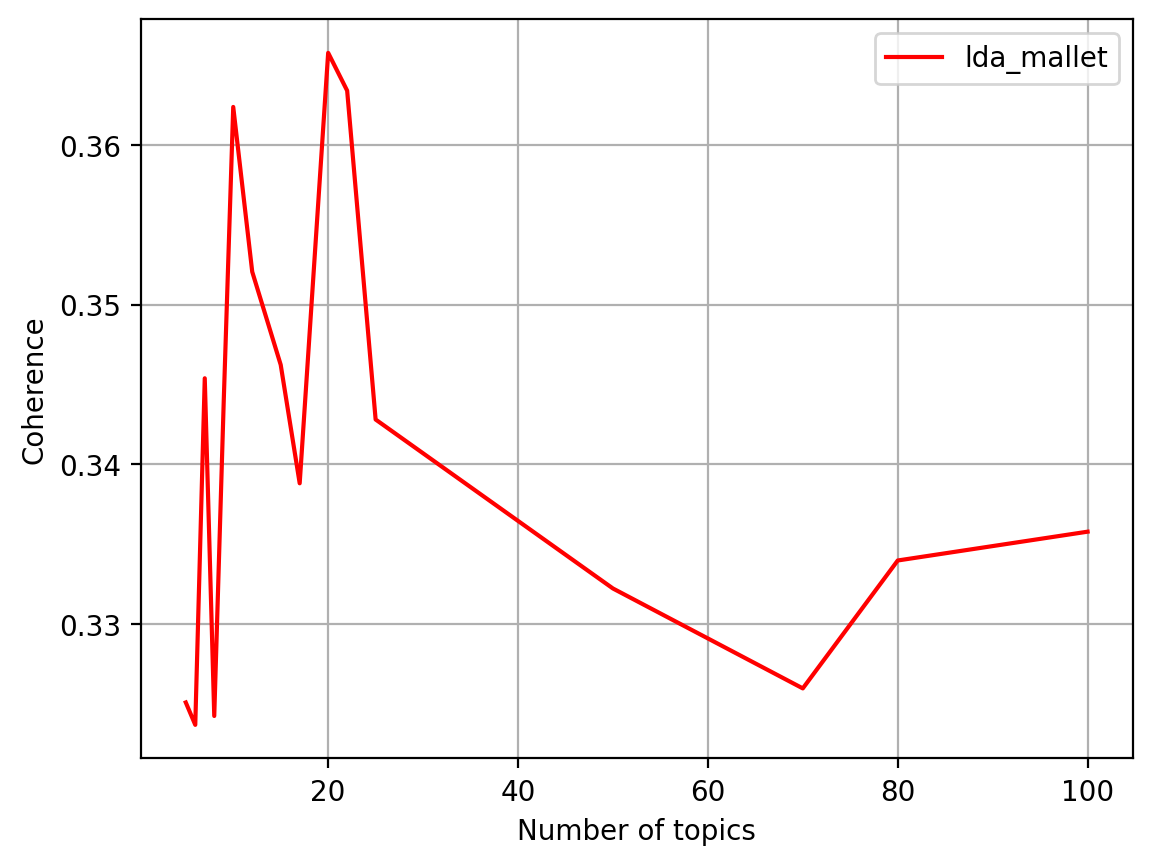

In [ ]:
topic_coherence_mallet = [] # For appending results
n_topics = [5, 6, 7, 8, 9, 10, 12, 15, 17, 20, 22, 25, 50, 70, 80, 100] # Given values

for ntopics in n_topics:
    ldamallet = LdaMallet(mallet_path, corpus=reviews_bow, num_topics=ntopics, id2word=D, alpha=5, iterations=1000); # Create model with ntopics
    coherence = CoherenceModel(ldamallet, texts=corpus, dictionary=D, coherence='c_v').get_coherence();
    topic_coherence_mallet.append(coherence);
    print(f'For n_topics = {ntopics}, Topic coherence = {coherence}')

plt.figure()
plt.plot(n_topics, topic_coherence_mallet, 'r', label='lda_mallet')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.legend()
plt.grid()
plt.show();

We choose 20 as the optimum number of topics as it is when the coherence is higher in the obtained plot at the end of the previus output cell.

In [ ]:
# We select num_topics=20
ldamallet = LdaMallet(mallet_path, corpus=reviews_bow, num_topics=20, id2word=D, alpha=5, iterations=1000)
ldagensim = malletmodel2ldamodel(ldamallet)

Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 630
total tokens: 248412
<10> LL/token: -9.59637
<20> LL/token: -9.19802
<30> LL/token: -9.0198
<40> LL/token: -8.9225

0	0.25	leave life woman friend night reason feel change adam year bar star wrong town ross end show thing time heart 
1	0.25	sex romance short hot scene erotic sex_scene erotica enjoy fun feel thing great sweet quick series sexy couple nice write 
2	0.25	write chapter page time review word thing writing point give free bad star finish writer mind type work main interesting 
3	0.25	make vampire kate leave human max work run turn humor funny michael write pride thing bell caleb emma interesting wait 
4	0.25	series mate werewolf wolf alpha pack human dragon shifter world meet enjoy female strong great vampire follow action paranormal sexy 
5	0.25	time people real point star work write sense bad start choice worth job deal rest provide main pay movie end 
6	0.25	time feel thing bad write issue 

Let's now check the list of the main 25 words in each topic, so that we can manually evaluate how discriminative is the obtained topic differentiation.

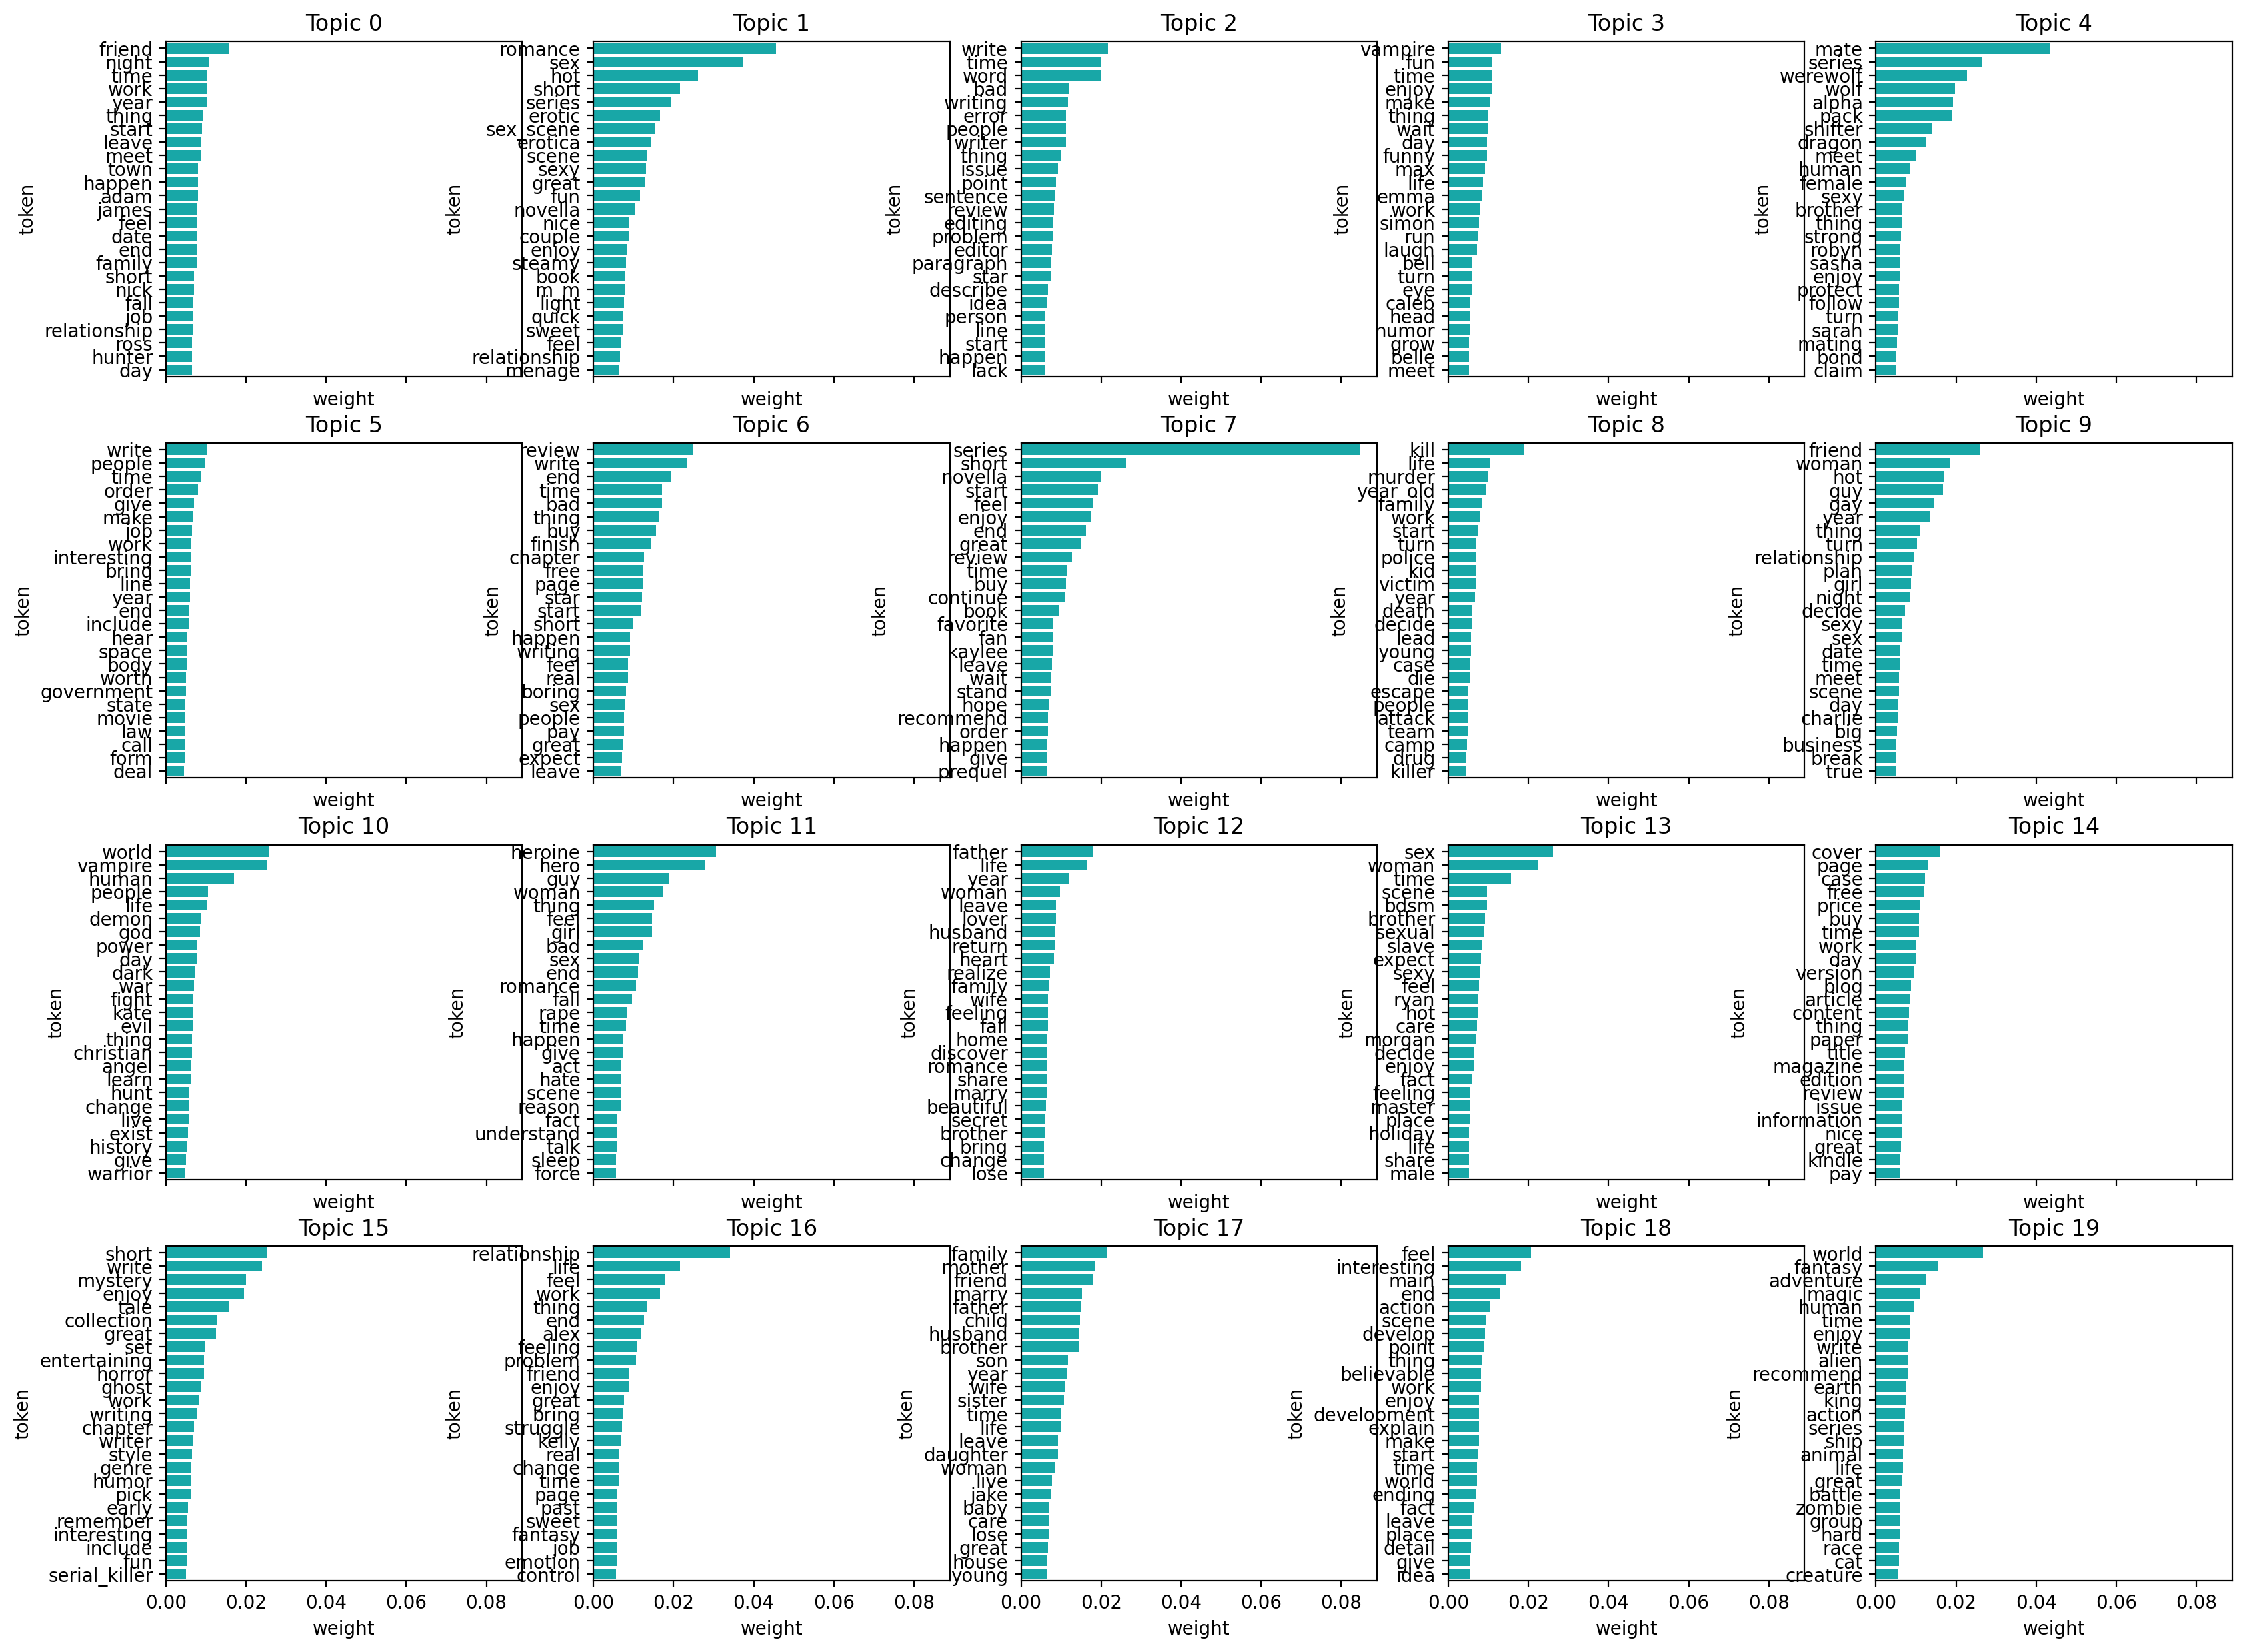

In [ ]:
topn = 25

fig, axes = plt.subplots(4,5, figsize=(20, 15), sharex=True)

# plot of the probabilities of each token for each topic
for i in range(20):
  # Build a dataframe with columns 'token' and 'weight' for topic i
  df = pd.DataFrame(ldamallet.show_topic(i, topn=topn), columns=['token','weight'])
  sns.barplot(x='weight', y='token',data=df, color='c', orient='h', ax=axes[i//5][i%5])
  axes[i//5][i%5].set_title('Topic ' + str(i))

# remove the unused subplots
for ax in axes.flatten()[20:]:
    ax.remove()


As we can see, there are some topics that could be quite discriminative;
- Topic 1, Erotic: romance, sex, erotic, sex_scene, couple,
- Topic 2, Grammar concepts: write, word, sentence, point, editor, paragraph, line,
- Topic 4, Criatures: werewolf, wolf, human, dragon, shifter,
- Topic 8, Killing: kill, life, murder, victim, die, attack
- Topic 10, Dual criatures: demon, angel, war, vampire, human, fight, warrior
- Topic 12, Cheating: husband, lover, family, wife, feeling, fall, discover, secret, marry, lose
- Topic 13, Sex: sex, bdsm, slave, sexual, hot,
- Topic 14, Reading formats: page, blog, article, magazine, title, edition, review, kindle
- Topic 15, Reading genres: mystery, horror, genre, humor
- Topic 17, Family: family, mother, father, child, husband, wife, daughter, baby, house

# Classification models

Lets test the different representations as inputs for each model.

## Labels and train/test split

In [ ]:
from gensim import matutils
from sklearn.model_selection import train_test_split

labels = np.array(data_30['rating'])

### For Word2Vec

In [ ]:
from gensim import matutils
from sklearn.model_selection import train_test_split

labels = np.array(data_50['rating'])

X_train_w2v, X_test_w2v, Y_train_w2v, Y_test_w2v = train_test_split(vectors, labels, test_size=.3, random_state=42)


### For TF-IDF

In [ ]:
from gensim import matutils
from sklearn.model_selection import train_test_split

labels = np.array(data_50['rating'])

X_train_w2v, X_test_w2v, Y_train_w2v, Y_test_w2v = train_test_split(vectors, labels, test_size=.3, random_state=42)


In [ ]:
from gensim.matutils import corpus2dense, corpus2csc
from sklearn.model_selection import train_test_split

labels = np.array(data_50['rating'])

n_tokens = len(D)
num_docs = len(reviews_bow)

# Convert TFIDF representacion
corpus_tfidf_dense = corpus2dense(reviews_tfidf, num_terms=n_tokens, num_docs=num_docs).T
corpus_tfidf_sparse = corpus2csc(reviews_tfidf, num_terms=n_tokens, num_docs=num_docs).T

In [ ]:
print(corpus_tfidf_sparse.shape)

(4156, 20091)


In [ ]:
X_train_TFIDF, X_test_TFIDF, Y_train_TFIDF, Y_test_TFIDF = train_test_split(corpus_tfidf_sparse, labels, test_size=.3, random_state=42)

### For LDA

In [ ]:
from gensim import matutils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Let's prepare the LDA obtained representation for being used as input of the classification model
document_topic_matrix = np.array(ldamallet[reviews_bow])
num_doc, num_topics, _ = document_topic_matrix.shape

document_topic_matrix_LDA = document_topic_matrix.reshape(num_doc, num_topics * 2)
print(document_topic_matrix_LDA.shape)


# Stratified split in train-test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_indices, test_indices = next(sss.split(document_topic_matrix_LDA, labels))

X_train_LDA, X_test_LDA = document_topic_matrix_LDA[train_indices], document_topic_matrix_LDA[test_indices]
Y_train_LDA, Y_test_LDA = labels[train_indices], labels[test_indices]


(4156, 40)


Finally, in order to compare the performance of different models for our dataset, we have also trained an SVR regressor.

# SVC

Although labels are discrete numbers from 1 to 5, we are training a regressor and rounding the result, to keep a sronger relation in similar numbers.

### SVC from LDA

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR, SVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Create SVM classifier
rang_C = np.logspace(-3,3,20)
rang_kernel = ['linear', 'rbf']
tuned_parameters = [{'C': rang_C,
                     'kernel': rang_kernel}]

# Train an SVM with CV
svc = GridSearchCV(SVC(),
                   tuned_parameters, cv=5, scoring='accuracy')
svc.fit(X_train_LDA, Y_train_LDA)

print('- The selected parameters in the cv are:')
print(f'C: {svc.best_estimator_.C}')
print(f'kernel: {svc.best_estimator_.kernel}')


- The selected parameters in the cv are:
C: 233.57214690901213
kernel: linear


- The accuracy over the test set is:37.93%
- The accuracy over the train set is: 40.80%


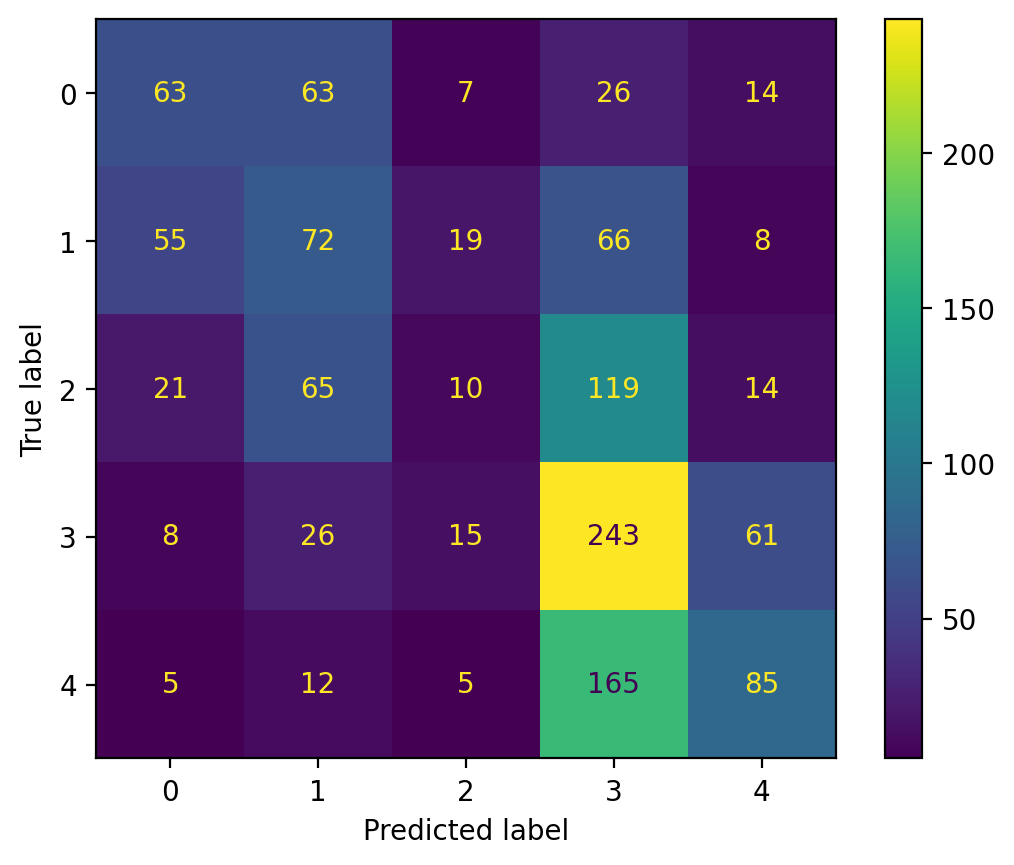

In [ ]:
print('- The accuracy over the test set is:{:.2f}%'.format(svc.score(X_test_LDA, Y_test_LDA)*100))
print('- The accuracy over the train set is: {:.2f}%'.format(svc.score(X_train_LDA, Y_train_LDA)*100))

y_pred = list(map(round, svc.predict(X_test_LDA)))

confusion_matrix = confusion_matrix(Y_test_LDA, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

As we can see by looking at the diagonal, we are not obtaining good results as the coherence between topics was really low. Many reviews that which label 3 have been predicted correctly but on the other hand, label 4 is sometimes being confused with label 3. This could be because these where writen based on people's opinions, so the information we obtain from a book review can be unclear when extracting the different topics.

### SVC from Word2Vec

In [ ]:
# Supress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore',module='compress_fasttext')

In [ ]:
print(matrix_w2v.shape)

(4157, 200)


In [ ]:
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR, SVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

X_train_w2v, X_test_w2v, Y_train_w2v, Y_test_w2v = train_test_split(vectors, labels, test_size=.3, random_state=42)

# Create SVM classifier
rang_C = np.logspace(-2,2,30)
rang_kernel = ['linear', 'rbf']
tuned_parameters = [{'C': rang_C,
                     'kernel': rang_kernel}]

# Train an SVM with CV
svc = GridSearchCV(SVC(),
                  tuned_parameters, cv=StratifiedKFold(n_splits=5,random_state=1,shuffle=True), scoring='accuracy')

svc.fit(X_train_w2v, Y_train_w2v)

print('- The selected parameters in the cv are:')
print(f'{svc.best_params_}')
print(f'C: {svc.best_estimator_.C}')
print(f'kernel: {svc.best_estimator_.kernel}')
print(f'C: {svc.best_estimator_.C}')


- The selected parameters in the cv are:
{'C': 20.433597178569418, 'kernel': 'rbf'}
C: 20.433597178569418
kernel: rbf
C: 20.433597178569418


- The accuracy over the test set is:42.10%
- The accuracy over the train set is: 50.81%


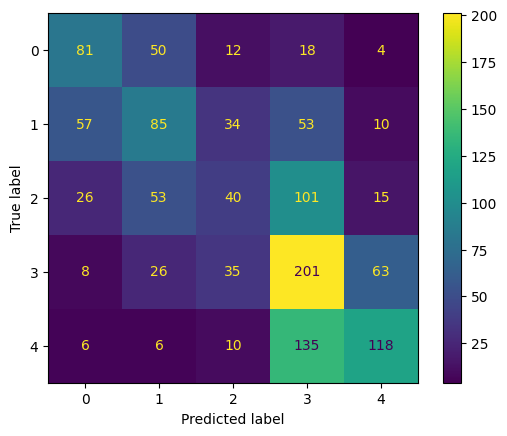

In [ ]:
print('- The accuracy over the test set is:{:.2f}%'.format(svc.score(X_test_w2v, Y_test_w2v)*100))
print('- The accuracy over the train set is: {:.2f}%'.format(svc.score(X_train_w2v, Y_train_w2v)*100))

y_pred = list(map(round, svc.predict(X_test_w2v)))

confusion_matrix = confusion_matrix(Y_test_w2v, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

As observed, many reviews of labels 3 and 4 are missclasified. This could be because of the similarity of this ratings as well as the unbalanced dataset we are dealing with, where the predominant class is the mayoritary one.

### SVC from TF-IDF

In [ ]:
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR, SVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Create SVM classifier
rang_C = np.logspace(-1,2,10)
rang_kernel = ['linear']
tuned_parameters = [{'C': rang_C,
                     'kernel': rang_kernel}]

# Train an SVM with CV
svc = GridSearchCV(SVC(),
                  tuned_parameters, cv=StratifiedKFold(n_splits=5,random_state=1,shuffle=True), scoring='accuracy')

svc.fit(X_train_TFIDF, Y_train_TFIDF)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ]),
                          'kernel': ['linear']}],
             scoring='accuracy')

In [ ]:
print('- The selected parameters in the cv are:')
print(f'{svc.best_params_}')


- The selected parameters in the cv are:
{'C': 1.0, 'kernel': 'linear'}


- The accuracy over the test set is:44.27%
- The accuracy over the train set is: 94.47%


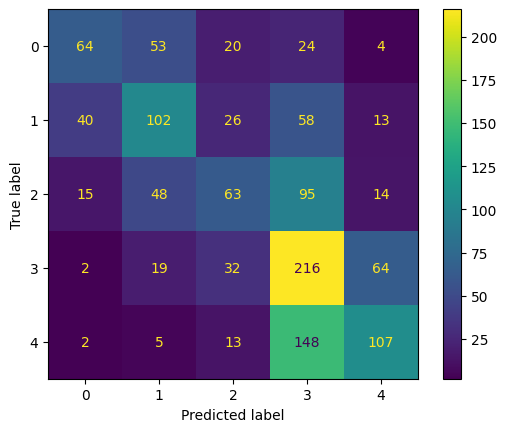

In [ ]:
print('- The accuracy over the test set is:{:.2f}%'.format(svc.score(X_test_TFIDF, Y_test_TFIDF)*100))
print('- The accuracy over the train set is: {:.2f}%'.format(svc.score(X_train_TFIDF, Y_train_TFIDF)*100))

y_pred = list(map(round, svc.predict(X_test_TFIDF)))

confusion_matrix = confusion_matrix(Y_test_TFIDF, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

# Transformers

In [ ]:
# Import the necessary libraries and modules

In [ ]:
!pip3 install transformers

In [ ]:
!pip install --upgrade tokenizer
!pip install --upgrade accelerate

In [ ]:
# Install necessary packages
import importlib, os

necessary_packages = ['transformers[sentencepiece]', 'datasets', 'gradio', 'colored', 'wikipedia', 'evaluate', 'nltk', 'rouge_score']
def import_missing(packages):
  for p in packages:
    try:
      mod = importlib.import_module(p)
      print(f"Package {p} already installed!")
      packages.remove(p)
    except ModuleNotFoundError:
      print(f"Installing package {p}")
      with open("requirements.txt", 'w') as f:
        f.write("\n".join(str(i) for i in packages))
  if os.path.isfile("requirements.txt"):
    %pip install --quiet -r "requirements.txt"

import_missing(necessary_packages)

Installing package transformers[sentencepiece]
Installing package datasets
Installing package gradio
Installing package colored
Installing package wikipedia
Installing package evaluate
Package nltk already installed!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 36.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
!pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cu111/torch_stable.html


In [ ]:
from transformers import BertTokenizer
from datasets import DatasetDict, Dataset, Features, ClassLabel, Value
from sklearn.model_selection import train_test_split

In [ ]:
# Define labels and initial checkpoint for fine-tuning
labels = np.array(data['rating'])
checkpoint_name = "bert-base-uncased"
sentences = data['reviewText'].tolist() # Use raw data as input
labels = [label - 1 for label in labels]

# Train, validation and test set, since we have a higher ammount of data
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Dataframe and dataset object
df_train = pd.DataFrame({"sentences": X_train, "label": y_train}) # define data set object
features_train = Features({"sentences": Value("string"), "label": ClassLabel(num_classes=5, names=[0,1,2,3,4])})
ds_train = Dataset.from_pandas(df_train, features=features_train)
ds_train.features


{'sentences': Value(dtype='string', id=None),
 'label': ClassLabel(names=[0, 1, 2, 3, 4], id=None)}

In [ ]:
# Dataframe and dataset object
df_test = pd.DataFrame({"sentences": X_test, "label": y_test})# define data set object
features_test  = Features({"sentences": Value("string"), "label": ClassLabel(num_classes=5, names=[0,1,2,3,4])})
ds_test  = Dataset.from_pandas(df_test , features=features_test)
ds_test.features

{'sentences': Value(dtype='string', id=None),
 'label': ClassLabel(names=[0, 1, 2, 3, 4], id=None)}

In [ ]:
# Dataframe and dataset object
df_valid = pd.DataFrame({"sentences": X_val, "label": y_val})# define data set object
features_valid   = Features({"sentences": Value("string"), "label": ClassLabel(num_classes=5, names=[0,1,2,3,4])})
ds_valid  = Dataset.from_pandas(df_valid , features=features_valid )
ds_valid.features

{'sentences': Value(dtype='string', id=None),
 'label': ClassLabel(names=[0, 1, 2, 3, 4], id=None)}

In [ ]:
# Final dataset
train_test_valid_dataset = DatasetDict({
    'train': ds_train,
    'test': ds_test,
    'valid': ds_valid})

In [ ]:
# Sample form train set with its corresponding label
train_test_valid_dataset["train"][0]

{'sentences': "Oliver Twist is one of Dickens' most liked and popular novels.Authors, let this be a lesson to you -- create terrific villains.Oliver Twist himself is a twerpy nobody 90% of the books. Okay, he asks for a second bowl of gruel. He fights to defend the good name of his mother. He walks to London in a week. That's all good, but it's all in the first quarter of the book.Afterward he does nothing but get entrapped by criminals. And be such an obvious goody-goody he becomes the friend of the victims instead.Indeed, the man who has a handkerchief stolen by the other two boys, and the family Bill Sykes tries to use Twist to rob turn out to be not only current friends but related to his real family.No author today could get away with such outrageous coincidences.The ending is a sentimental mishmash. He has a half-brother who hates him, and people are involved in complicated plots I could neither follow nor believe.What makes this novel live on is the portrait of Fagin the leader 

In [ ]:
# Suffle data
train_test_valid_dataset = DatasetDict({
    "train": train_test_valid_dataset["train"].shuffle(seed=42),
    "test": train_test_valid_dataset["test"].shuffle(seed=42),
    "val": train_test_valid_dataset["valid"].shuffle(seed=42),
    })

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(checkpoint_name)

def tokenize_function(example):
  return tokenizer(example["sentences"], truncation=True)

tokenized_dataset = train_test_valid_dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/8400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentences', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8400
    })
    test: Dataset({
        features: ['sentences', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1800
    })
    val: Dataset({
        features: ['sentences', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1800
    })
})

Let's implement the **data collator**, for combining and adding padding to the input data.

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Now check the length of first 8 samples before and after the collator.

In [ ]:
samples = tokenized_dataset["train"][:8]
[len(x) for x in samples["input_ids"]]

[33, 228, 121, 104, 66, 89, 32, 31]

In [ ]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 228]),
 'token_type_ids': torch.Size([8, 228]),
 'attention_mask': torch.Size([8, 228])}

We correctly add padding to the shorter samples up to the longest one.

Now let's **fine tune** the transformer.

In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification

# Load model from checkpoint
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_name, num_labels=5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
training_args = TrainingArguments(output_dir=f"{checkpoint_name}-finetuned-kindle")

In [ ]:
training_args.num_train_epochs=10 # increase the number of epochs for a better performance

Now we define the trainer object:

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train() # Using all data

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,1.188900
1000,1.063300
1500,0.861700
2000,0.889700
2500,0.653500
3000,0.618600
3500,0.493700
4000,0.447800
4500,0.348600
5000,0.333300


TrainOutput(global_step=10500, training_loss=0.38385979861304875, metrics={'train_runtime': 5567.2876, 'train_samples_per_second': 15.088, 'train_steps_per_second': 1.886, 'total_flos': 1.5272791248626304e+16, 'train_loss': 0.38385979861304875, 'epoch': 10.0})

Now lets obtain the transformer prediction and display the corresponding confusion matrix:

In [ ]:
predictions = trainer.predict(tokenized_dataset["val"])
print(predictions.predictions.shape, predictions.label_ids.shape)

(720, 5) (720,)


In [ ]:
preds = np.argmax(predictions.predictions, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score

labels = tokenized_dataset["val"]["labels"]

accuracy_score(y_true=labels, y_pred=preds)

0.555

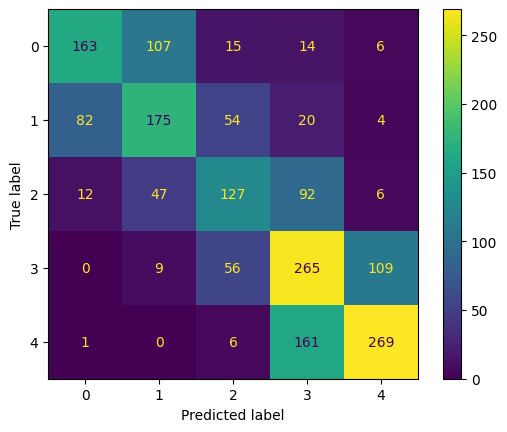

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sklearn.metrics as metrics

# Convert y_pred to a numpy array
y_pred_np = np.array(preds)

# Compute the confusion matrix
cm = confusion_matrix(labels, y_pred_np)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()  # data_50 con limite 25

As we can see the transofrmers pre trained model has outperformed the SVC models with all the vector representations proposed. When looking at the confusion matrix we can see in the diagonal the classes that have been correctly predicted that have a higher number of matches than the previous models. Also we should take into consideration that the highes missclassified reviews are the ones from the most frequent output, that are also the closest ones (represented as 3 and 4 in the matrix).

# Extension work

As extension work, we will include some aditional study of the results obtained for each model. Although it is not directly a different NLP technique (due to time limitations), it will will help us to extract additional information of the already performed work.



In [ ]:
import numpy as np
cm_lda = np.array([
    [63, 63, 7, 26, 14],
    [55, 72, 19, 66, 8],
    [21, 65, 10, 119, 14],
    [8, 26, 15, 243, 61],
    [5, 12, 5, 165, 85]
])

cm_w2v = np.array([
    [81, 50, 12, 18, 4],
    [57, 85, 34, 53, 10],
    [26, 53, 40, 101, 15],
    [8, 26, 35, 201, 63],
    [6, 6, 10, 135, 118]
])

cm_tfidf = np.array([
    [64, 53, 20, 24, 4],
    [40, 102, 26, 58, 13],
    [15, 48, 63, 95, 14],
    [2, 19, 32, 216, 64],
    [2, 5, 13, 148, 107]
])

cm_trans = np.array([
    [163, 107, 15, 14, 6],
    [82, 175, 54, 20, 4],
    [12, 47, 127, 92, 6],
    [0, 9, 56, 265, 109],
    [1, 0, 6, 161, 269]
])

cm_list = [cm_lda, cm_w2v, cm_tfidf, cm_trans]

In [ ]:
import matplotlib.pyplot as plt

def extract_information(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    total_samples = confusion_matrix.sum()
    aciertos = 0
    errores = [0, 0, 0, 0]

    for i in range(num_classes):
        for j in range(num_classes):
            difference = abs(i - j)
            if difference == 0:
                aciertos += confusion_matrix[i, j]
            elif difference <= 4:
                errores[difference-1] += confusion_matrix[i, j]
    aciertos = (aciertos / total_samples) * 100
    errores = [(error / total_samples) * 100 for error in errores]

    return aciertos, *errores


In [ ]:
import pandas as pd

nombres = ['LDA', 'W2V', 'TF-IDF', 'Transformers']

def create_confusion_matrix_dataframe(confusion_matrices, names):
    data = []
    column_names = ['Name', 'Correct', 'error_1', 'error_2', 'error_3', 'error_4']

    for index, confusion_matrix in enumerate(confusion_matrices):
        result = extract_information(confusion_matrix)
        row = [names[index]] + list(result)
        data.append(row)

    df = pd.DataFrame(data, columns=column_names)
    return df


df = create_confusion_matrix_dataframe(cm_list, nombres)
df

,Name,Correct,error_1,error_2,error_3,error_4
0,LDA,37.931034,45.068164,11.146752,4.330393,1.523657
1,W2V,42.101043,42.341620,11.387330,3.368083,0.801925
2,TF-IDF,44.266239,40.577386,11.146752,3.528468,0.481155
3,Transformers,55.500000,39.333333,3.777778,1.000000,0.388889


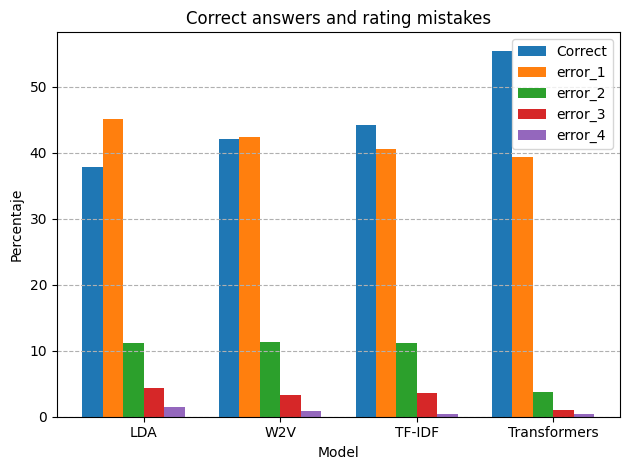

In [ ]:
import matplotlib.pyplot as plt

# Configuración del gráfico
bar_width = 0.15
index = np.arange(len(df))  # Utilizar arange en lugar de range

# Crear el gráfico de barras
fig, ax = plt.subplots()
for i, column in enumerate(df.columns[1:]):
    ax.bar(index + (i * bar_width), df[column], bar_width, label=column)  # Ajustar la posición de las barras

# Configurar ejes y etiquetas
ax.set_xlabel('Model')
ax.set_ylabel('Percentaje')
ax.set_title('Correct answers and rating mistakes')
ax.set_xticks(index + (bar_width * (len(df.columns[1:]) / 2)))  # Ajustar las posiciones de las etiquetas
ax.set_xticklabels(df['Name'])
ax.legend()
plt.grid(axis='y', linestyle='--')
# Mostrar el gráfico
plt.tight_layout()
plt.show()
